# Home Equity Line of Credit (Loan Default Prediction with XGBoost)

## Project Overview

This project leverages machine learning to predict loan defaults using an XGBoost classification model. The dataset used in this project includes a variety of financial and employment-related features that influence a borrower's likelihood of defaulting on a Home Equity Line of Credit (HELOC).

The key goals of this project include:

- Exploring and understanding the dataset through visualization and statistics
- Cleaning and preprocessing the data for model readiness
- Applying the XGBoost algorithm for classification
- Evaluating model performance using classification metrics
- Interpreting feature importance to guide lending decisions
- Providing insights and recommendations to reduce loan default risk

## Tools and Technologies

- Python
- Pandas & NumPy for data manipulation
- Matplotlib & Seaborn for data visualization
- Scikit-learn for preprocessing and model evaluation
- XGBoost for building the predictive model

## Dataset Features

Some of the key features include:

- `DEBTINC`: Debt-to-Income Ratio
- `CLAGE`: Age of the oldest credit line
- `MORTDUE`: Amount due on existing mortgage
- `VALUE`: Value of current property
- `LOAN`: Requested loan amount
- `CLNO`: Number of existing credit lines
- `YOJ`: Years at current job
- `JOB`: Type of job
- `DELINQ`: Number of delinquent credit lines

## Target Variable

- `DEFAULT`: Indicates whether the borrower defaulted (1) or not (0)

---

> **Note**: This project serves as both an analytical exercise and a practical guide for financial analysts, credit risk officers, and data scientists working in the finance and lending industries.



In [2]:
#uploading the heloc dataset

import pandas as pd
import numpy as np

# Load the dataset from Excel
data = pd.read_excel('Heloc.xlsx')

# Quick look at the data
data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [4]:
# understanding the dataset
print(data.shape)
print(data.info())

# Summary statistics
print(data.describe())

# Missing values count
print(data.isnull().sum())

(5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
None
               BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std   

In [7]:
#Cleaning and Pre-processing

# Identify numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Fill missing numeric values with median
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# For categorical columns fill missing with mode or 'Missing'
categorical_cols = ['REASON', 'JOB']
for col in categorical_cols:
    data[col] = data[col].fillna('Missing')

In [9]:
# Checking the data again after cleaning
print(data.shape)
print(data.info())

# Summary statistics
print(data.describe())

# Missing values count
print(data.isnull().sum())

(5960, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5960 non-null   object 
 5   JOB      5960 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
None
               BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5960.000000    5960.000000  5960.000000   
mean      0.199497  18607.969799   73001.041812  101540.387423     8.756166   
std   

In [12]:
#saving the clean dataset

data.to_excel("Heloc_cleaned.xlsx", index=False)

In [14]:
#converting categorical variables

data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [16]:
#Feature Engineering

# Loan-to-Value ratio
data['LOAN_TO_VALUE'] = data['LOAN'] / data['VALUE']

# Mortgage-to-Value ratio
data['MORTGAGE_TO_VALUE'] = data['MORTDUE'] / data['VALUE']

# Handle infinities or NaNs from division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)

In [18]:
#preparing data for modelling

X = data.drop('BAD', axis=1)
y = data['BAD']

In [20]:
#training and testing set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
#building logistic regression model

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
#evaluating the model

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))

print('ROC AUC:', roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       954
           1       0.00      0.00      0.00       238

    accuracy                           0.80      1192
   macro avg       0.40      0.50      0.44      1192
weighted avg       0.64      0.80      0.71      1192

ROC AUC: 0.6021572150872927


C:\Users\aleji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aleji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
#feature importance

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance)

              feature   coefficient
6               CLAGE -5.804909e-03
3                 YOJ -2.015452e-04
8                CLNO -1.289104e-04
5              DELINQ  1.040875e-04
9             DEBTINC -6.869095e-05
7                NINQ  6.685291e-05
4               DEROG  5.931662e-05
0                LOAN -1.844032e-05
13         JOB_Office -1.107270e-05
12        JOB_Missing -6.103775e-06
1             MORTDUE -4.673895e-06
15        JOB_ProfExe -3.915574e-06
19  MORTGAGE_TO_VALUE -3.810728e-06
10     REASON_HomeImp -3.607144e-06
17           JOB_Self  3.339823e-06
2               VALUE  2.459079e-06
18      LOAN_TO_VALUE -2.162618e-06
16          JOB_Sales  1.979197e-06
11     REASON_Missing -1.798131e-06
14          JOB_Other  1.576980e-07


C:\Users\aleji\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


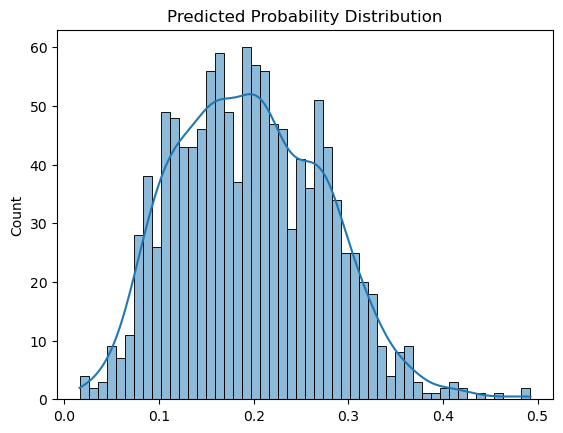

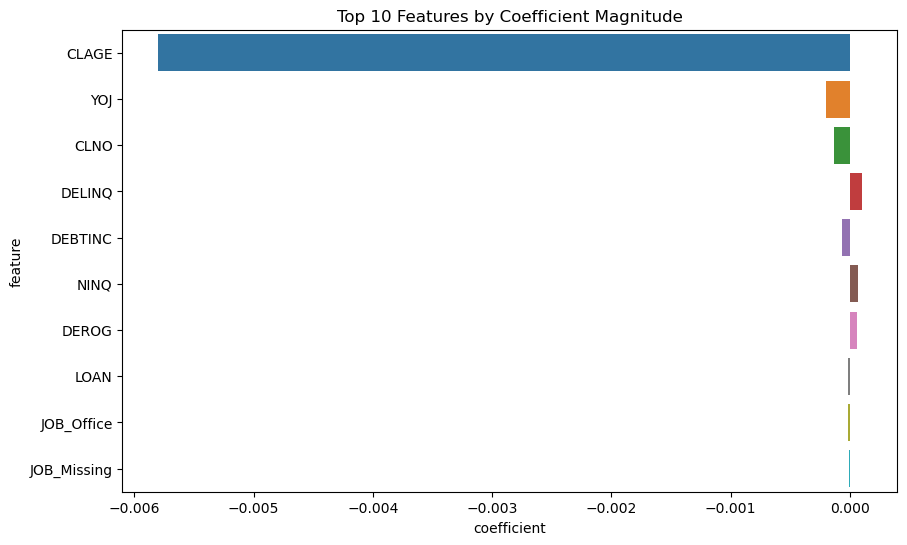

In [28]:
#visualization of feature importance

import matplotlib.pyplot as plt
import seaborn as sns

# Predicted probabilities distribution
sns.histplot(y_prob, bins=50, kde=True)
plt.title('Predicted Probability Distribution')
plt.show()

# Top 10 feature coefficients
plt.figure(figsize=(10,6))
sns.barplot(x='coefficient', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Features by Coefficient Magnitude')
plt.show()

In [30]:
#preparing for xgboost model

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [32]:
#load data

df = pd.read_excel("Heloc.xlsx")

In [34]:
#preprocessing

df.replace(-9, np.nan, inplace=True)
df.dropna(inplace=True)

In [36]:
#preprocessing

X = df.drop('BAD', axis=1)
y = df['BAD']

In [38]:
#train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [40]:
#training xgboost model

from sklearn.preprocessing import LabelEncoder

# Make a copy if needed
df_encoded = df.copy()

# Encode REASON and JOB
label_encoders = {}
for col in ['REASON', 'JOB']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Redefine X and y
X = df_encoded.drop('BAD', axis=1)
y = df_encoded['BAD']

In [42]:
#train-test split model

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [44]:
#train xgboost model

# Calculate scale_pos_weight
weight = (y == 0).sum() / (y == 1).sum()

model = XGBClassifier(scale_pos_weight=weight, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

C:\Users\aleji\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:11:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [46]:
#predictions and evaluations

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC AUC Score:")
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       613
           1       0.93      0.65      0.76        60

    accuracy                           0.96       673
   macro avg       0.95      0.82      0.87       673
weighted avg       0.96      0.96      0.96       673

Confusion Matrix:
[[610   3]
 [ 21  39]]
ROC AUC Score:
0.9197117998912452


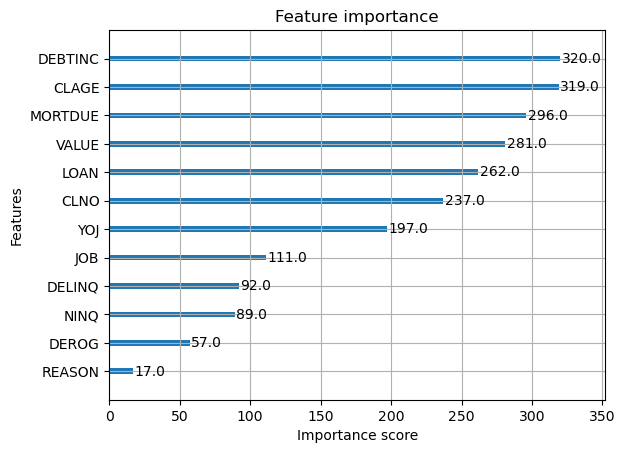

In [47]:
#feature importance plot

import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()